# Predict Next Purchase

In this example, we will generate labels on online grocery orders provided by Instacart using Compose. The labels can be used to train a machine learning model to predict whether a customer will buy a specific product within the next month.

If you plan to run this notebook, you can use the following command at the root directory of the repository.

```bash
jupyter notebook docs/source/examples/predict-next-purchase/example.ipynb
```

## Load Data

In [1]:
%matplotlib inline
import composeml as cp
import featuretools as ft
from demo.predict_next_purchase import load_sample
from evalml import AutoMLSearch
from evalml.preprocessing import split_data

The data hosted [here](https://www.instacart.com/datasets/grocery-shopping-2017) will be downloaded automatically into the `data` module of this notebook unless it already exist. Once the data is in place, we can preview the grocery orders to see how they look.

In [2]:
df = load_sample()

df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,order_time
id,,,,,,,,,,
0,120,33120,13,0,Organic Egg Whites,86,16,dairy eggs,23750,2015-01-11 08:00:00
1,120,31323,7,0,Light Wisconsin String Cheese,21,16,dairy eggs,23750,2015-01-11 08:00:00
2,120,1503,8,0,Low Fat Cottage Cheese,108,16,dairy eggs,23750,2015-01-11 08:00:00
3,120,28156,11,0,Total 0% Nonfat Plain Greek Yogurt,120,16,dairy eggs,23750,2015-01-11 08:00:00
4,120,41273,4,0,Broccoli Florets,123,4,produce,23750,2015-01-11 08:00:00


## Generate Labels
Now with the grocery orders loaded, we are ready to generate labels for our prediction problem.

### Create Labeling Function
To get started, we define the labeling function that will return whether a customer purchased the product in a given month.

In [3]:
def bought_product(df, product_name):
    return df.product_name.str.contains(product_name).any()

### Construct Label Maker

With the labeling function, we create the label maker for our prediction problem. To process one month of orders for each customer, we set the `target_entity` to the customer ID and the `window_size` to one month. When window size is set to `1MS`, the window size will end on the first day of the next month. Alias definitions are listed [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [4]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='1w',
)

### Search Labels
Next, the label maker will search through the data continously to label whether a customer bought bananas in a given month. This happens when we use `LabelMaker.search` and set the `product_name` to bananas. If you are running this code yourself, feel free to expirement with other products (e.g. limes, avocados, etc.) and different time frames!

In [5]:
lt = lm.search(
    df.sort_values('order_time'),
    minimum_data='3d',
    num_examples_per_instance=-1,
    product_name='Banana',
    gap='3d',
    verbose=True,
)

lt.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| user_id: 284/284 


,user_id,time,bought_product
0,2555,2015-01-19 09:00:00,False
1,2555,2015-01-22 09:00:00,False
2,3283,2015-01-08 13:00:00,True
3,5360,2015-01-18 11:00:00,False
4,5360,2015-01-21 11:00:00,False


### Describe Labels

With the generate label times, we can use `LabelTimes.describe` to print out the distribution with the settings and transforms that were used to make these labels. This is useful as a reference for understanding how the labels were generated from raw data. Also, the label distribution is helpful for determining if we have imbalanced labels.

In [6]:
lt.describe()

Label Distribution
------------------
False     27
True      24
Total:    51


Settings
--------
gap                                      3d
minimum_data                             3d
num_examples_per_instance                -1
target_column                bought_product
target_entity                       user_id
target_type                        discrete
window_size                              1w


Transforms
----------
No transforms applied



### Plot Labels

Additionally, there are plots available for insight to the labels.

#### Distribution

This plot shows the label distribution.

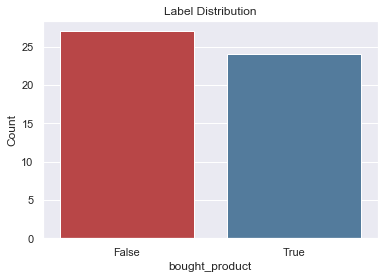

In [7]:
lt.plot.distribution();

#### Count by Time

This plot shows the label distribution across cutoff times.

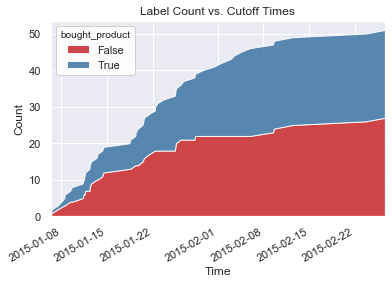

In [8]:
lt.plot.count_by_time();

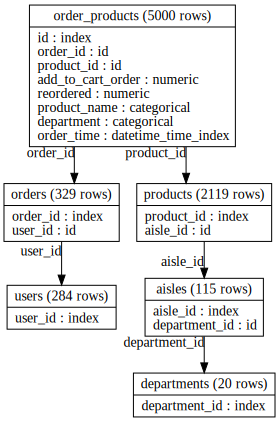

In [9]:
es = ft.EntitySet('instacart')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='order_products',
    time_index='order_time',
    index='id',
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='orders',
    index='order_id',
    additional_variables=['user_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='orders',
    new_entity_id='users',
    index='user_id',
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='products',
    index='product_id',
    additional_variables=['aisle_id', 'department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='products',
    new_entity_id='aisles',
    index='aisle_id',
    additional_variables=['department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='aisles',
    new_entity_id='departments',
    index='department_id',
    make_time_index=False,
)

es["order_products"]["department"].interesting_values = ['produce']
es["order_products"]["product_name"].interesting_values = ['Banana']
es.plot()

In [10]:
X, features = ft.dfs(
    entityset=es,
    target_entity='users',
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

X.head()

COUNT(orders)  SUM(order_products.reordered)  \
user_id time                                                                
2555    2015-01-19 09:00:00              2                              2   
        2015-01-22 09:00:00              2                              2   
3283    2015-01-08 13:00:00              2                              6   
5360    2015-01-18 11:00:00              2                             37   
        2015-01-21 11:00:00              2                             37   

                             SUM(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-19 09:00:00                                      3   
        2015-01-22 09:00:00                                      3   
3283    2015-01-08 13:00:00                                     28   
5360    2015-01-18 11:00:00                                    903   
        2015-01-21 11:00:00                                    903   

                             STD(order_products.reordered)  \
user_id time                                                 
2555    2015-01-19 09:00:00                       0.000000   
        2015-01-22 09:00:00                       0.000000   
3283    2015-01-08 13:00:00                       0.377964   
5360    2015-01-18 11:00:00                       0.327770   
        2015-01-21 11:00:00                       0.327770   

                             STD(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-19 09:00:00                               0.707107   
        2015-01-22 09:00:00                               0.707107   
3283    2015-01-08 13:00:00                               2.160247   
5360    2015-01-18 11:00:00                              12.267844   
        2015-01-21 11:00:00                              12.267844   

                             MAX(order_products.reordered)  \
user_id time                                                 
2555    2015-01-19 09:00:00                              1   
        2015-01-22 09:00:00                              1   
3283    2015-01-08 13:00:00                              1   
5360    2015-01-18 11:00:00                              1   
        2015-01-21 11:00:00                              1   

                             MAX(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-19 09:00:00                                      2   
        2015-01-22 09:00:00                                      2   
3283    2015-01-08 13:00:00                                      7   
5360    2015-01-18 11:00:00                                     42   
        2015-01-21 11:00:00                                     42   

                             SKEW(order_products.reordered)  \
user_id time                                                  
2555    2015-01-19 09:00:00                             NaN   
        2015-01-22 09:00:00                             NaN   
3283    2015-01-08 13:00:00                       -2.645751   
5360    2015-01-18 11:00:00                       -2.440735   
        2015-01-21 11:00:00                       -2.440735   

                             SKEW(order_products.add_to_cart_order)  \
user_id time                                                          
2555    2015-01-19 09:00:00                                     NaN   
        2015-01-22 09:00:00                                     NaN   
3283    2015-01-08 13:00:00                                     0.0   
5360    2015-01-18 11:00:00                                     0.0   
        2015-01-21 11:00:00                                     0.0   

                             MIN(order_products.reordered)  ...  \
user_id time                                                ...   
2555    2015-01-19 09:00:00                              1  ...   
     

In [11]:
y = X.pop('bought_product')

y.head()

user_id  time               
2555     2015-01-19 09:00:00    False
         2015-01-22 09:00:00    False
3283     2015-01-08 13:00:00     True
5360     2015-01-18 11:00:00    False
         2015-01-21 11:00:00    False
Name: bought_product, dtype: bool

In [12]:
X_train, X_holdout, y_train, y_holdout = split_data(
    X=X,
    y=y,
    test_size=0.3,
    random_state=0,
)

In [13]:
automl = AutoMLSearch(
    problem_type='binary',
    objective='f1',
    random_state=0,
)

automl.search(X_train, y_train, data_checks=None)

Using default limit of max_pipelines=5.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1. 
Greater score is better.

Searching up to 5 pipelines. 
Allowed model families: xgboost, linear_model, random_forest, catboost



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

(1/5) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.000
(2/5) CatBoost Classifier w/ Simple Imputer    Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.803
(3/5) XGBoost Classifier w/ Simple Imputer ... Elapsed:00:09
	Starting cross validation
	Finished cross validation - mean F1: 0.833
(4/5) Random Forest Classifier w/ Simple Im... Elapsed:00:12
	Starting cross validation
	Finished cross validation - mean F1: 0.859
(5/5) Logistic Regression Classifier w/ Sim... Elapsed:00:16
	Starting cross validation
	Finished cross validation - mean F1: 0.822

Search finished after 00:28            
Best pipeline: Random Forest Classifier w/ Simple Imputer + One Hot Encoder
Best pipeline F1: 0.858586


****************************************************************
* Random Forest Classifier w/ Simple Imputer + One Hot Encoder *
****************************************************************

Problem Type: Binary Classification
Model Family: Random Forest

Pipeline Steps
1. Simple Imputer
	 * impute_strategy : most_frequent
	 * fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * categories : None
	 * drop : None
	 * handle_unknown : ignore
	 * handle_missing : error
3. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1


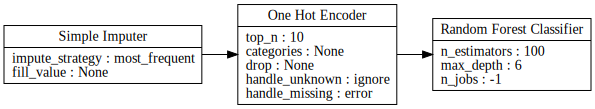

In [14]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

In [15]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['f1'],
)

dict(score)

{'F1': 0.7142857142857143}